### Retailer Sales Data Forecasting

This dataset contains the daily sales data of a US retailer.  
Your objective is to forecast the total sales for each State over the next 12 months, using the historical data provided.


### Part 1: Top-Down Approach

1. **Aggregate Sales:**  
   Combine the sales data to create total sales at the `year-month` level, using the `Order Date` as the time variable for aggregation.


2. **Train a Model:**  
   Using the aggregated `year-month` data, train a model to forecast the total sales for the next 12 months.  
   *(The choice of model is up to you.)*

3. **Disaggregate Predictions:**  
   Split the predicted sales from the `year-month` level back to the `year-month-State` level.  
   *(The splitting strategy is up to you.)*

4. **Evaluate Accuracy:**  
   Assess the forecast accuracy at both the `year-month` and `year-month-State` levels.


# ____________________________________________________________

### Part 2: Alternative Approach

- Implement a different approach to forecast the next 12 months of sales at the `year-month-State` level.


# ____________________________________________________________

In [1]:
# Libraries
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt



# ETL

In [2]:
# Load the dataset
df = pd.read_csv('Retailer Sales Data.csv')

# Convert 'Order Date' and 'Ship Date' columns to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')


In [3]:
# Print the number of missing values where both 'Ship Date' and 'Order Date' are missing
print("Number of missing values on 'Ship Date' and 'Order Date':", 
      df[df['Ship Date'].isnull() & df['Order Date'].isnull()].shape[0])

# Calculate shipping days as the difference between 'Ship Date' and 'Order Date'
df['Shipping_days'] = df['Ship Date'] - df['Order Date']

# Calculate the average shipping days
avg_shipping_days = df['Shipping_days'].mean()

# Impute missing 'Order Date' by subtracting the average shipping days from 'Ship Date'
df.loc[df['Order Date'].isnull(), 'Order Date'] = df['Ship Date'] - pd.to_timedelta(avg_shipping_days, unit='D')

# Drop rows where 'Order Date' is still missing
df = df[df['Order Date'].notna()]

# Create a new column 'Year-Month' for the order date at a monthly granularity
df['Year-Month'] = df['Order Date'].dt.to_period('M')

# Identify and print missing months in the dataset
missing_months = pd.period_range(start=df['Year-Month'].min(), 
                                 end=df['Year-Month'].max(), 
                                 freq='M').difference(df['Year-Month'])
print("Missing months of sales:", missing_months)

# Clean up by removing the temporary variable
del avg_shipping_days


Number of missing values on 'Ship Date' and 'Order Date': 14
Missing months of sales: PeriodIndex([], dtype='period[M]')


In [4]:
# Print number of rows with missing 'Sales' and 'Sub-Category'
print("Number of missing values on 'Sales' and 'Sub-Category':", 
      df[['Sales', 'Sub-Category']].isnull().all(axis=1).sum())

# Calculate average sales by 'Sub-Category' and 'Category'
avg_sales_sub_cat = df.groupby('Sub-Category')['Sales'].mean()
avg_sales_cat = df.groupby('Category')['Sales'].mean()

# Impute missing 'Sales' with average sales by 'Sub-Category' and 'Category'
df['Sales'] = df['Sales'].fillna(df['Sub-Category'].map(avg_sales_sub_cat))
df['Sales'] = df['Sales'].fillna(df['Category'].map(avg_sales_cat))

# Drop rows with still missing 'Sales'
df.dropna(subset=['Sales'], inplace=True)

# Clean up
del avg_sales_sub_cat
del avg_sales_cat


Number of missing values on 'Sales' and 'Sub-Category': 23


In [5]:
# Check if any 'Customer ID' has more than one 'Customer Name'
print((df.groupby('Customer ID')['Customer Name'].nunique() > 1).sum())

# Create a dictionary to map 'Customer ID' to the first non-null 'State'
state_fill_dict = df.dropna(subset=['State']).groupby('Customer ID')['State'].first().to_dict()

# Fill missing 'State' values based on 'Customer ID'
df['State'] = df['State'].fillna(df['Customer ID'].map(state_fill_dict))

# Create a dictionary to map 'Country' to the first non-null 'State'
city_fill_dict = df.dropna(subset=['State', 'Country']).groupby('Country')['State'].first().to_dict()

# Fill remaining missing 'State' values based on 'Country'
df.loc[df['State'].isna() & df['Country'].notna(), 'State'] = df['Country'].map(city_fill_dict)

# Drop rows where 'State' is still missing
df.dropna(subset=['State'], inplace=True)

# Check for any remaining missing values in 'State'
print(df['State'].isna().sum())

# Clean up
del city_fill_dict
del state_fill_dict


0
0


# ____________________________________________________________

# Modeling

### SARIMA


##### Year - Month Level

In [6]:
# Group sales data by 'Year-Month' and 'State', then sum the sales
monthly_sales_state = df.groupby(['Year-Month', 'State'])['Sales'].sum().reset_index()

# Aggregate sales by 'Year-Month'
monthly_sales = monthly_sales_state.groupby(['Year-Month'])['Sales'].sum()

# Pivot the sales data to get sales by 'State' in columns
sales_by_state = monthly_sales_state.groupby(['Year-Month', 'State'])['Sales'].sum().unstack().fillna(0)

# Calculate the proportion of sales by state for each month
state_proportions = sales_by_state.div(sales_by_state.sum(axis=1), axis=0)

# Split the data into training and test sets based on date
train_data = monthly_sales[monthly_sales.index < '2018-01']
test_data = monthly_sales[monthly_sales.index >= '2018-01']



In [7]:

# Define SARIMA model parameters
p, d, q = 1, 1, 1  # ARIMA parameters
P, D, Q, s = 1, 1, 1, 12  # Seasonal parameters (s=12 for monthly data)

# Train the SARIMA model
model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)


/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


#####  Model Evaluation at Year - Month Level

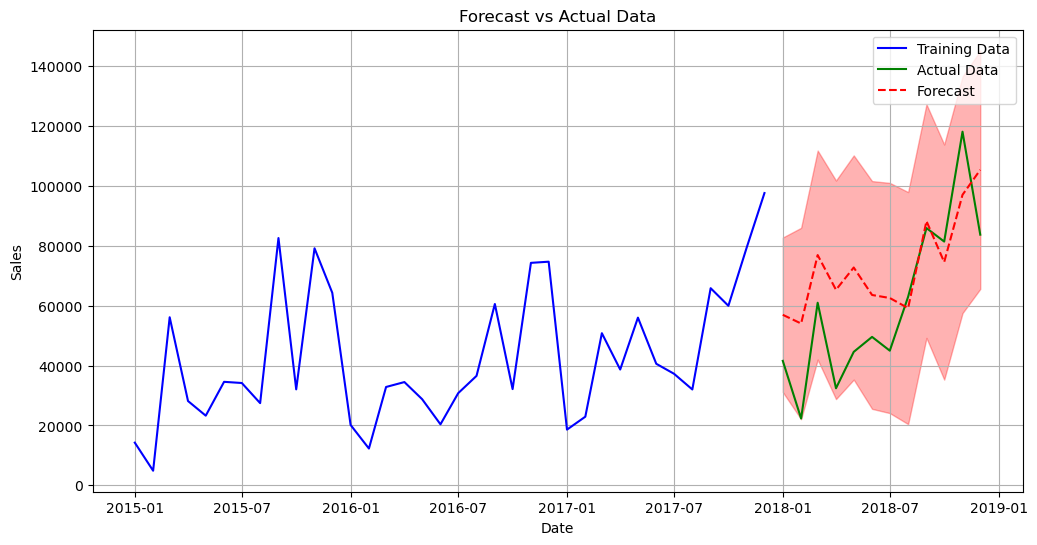

In [8]:
# Make forecasts for the next 12 periods
forecast = model_fit.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Create a Series for forecasted values
forecast_index = pd.period_range(start='2018-01', periods=12, freq='M')
forecast_series = pd.Series(forecast_values, index=forecast_index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index.to_timestamp(), train_data, label='Training Data', color='blue')
plt.plot(test_data.index.to_timestamp(), test_data, label='Actual Data', color='green')
plt.plot(forecast_series.index.to_timestamp(), forecast_series, label='Forecast', color='red', linestyle='--')
plt.fill_between(forecast_series.index.to_timestamp(), 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)
plt.title('Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [9]:

# Evaluate forecast accuracy using MSE, RMSE, and MAE
mse = mean_squared_error(test_data, forecast_series)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast_series)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Mean Squared Error (MSE): 404944669.73
Root Mean Squared Error (RMSE): 20123.24
Mean Absolute Error (MAE): 17618.75


##### Year - Month proportioned by States

In [10]:

# Create a DataFrame to hold proportionally forecasted values for each state
forecast_proportioned = pd.DataFrame(index=forecast_series.index, columns=state_proportions.columns)

# Allocate the total forecasted values proportionally across states
for state in state_proportions.columns:
    forecast_proportioned[state] = forecast_series * state_proportions[state]


#####  Model Evaluation at Year - Month  - states Level

In [11]:
# Reconstruct the actual test data for each state based on historical proportions
test_data_state = pd.DataFrame(index=test_data.index, columns=state_proportions.columns)

# Multiply the total test data by the historical proportions for each state
for state in state_proportions.columns:
    test_data_state[state] = test_data * state_proportions[state]

    from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prepare a list to store the results
results = []

# Calculate metrics for each state
for state in forecast_proportioned.columns:
    actual_data = test_data_state[state]  # Actual data for the state
    forecast_data = forecast_proportioned[state]  # Forecasted data for the state
    
    mse = mean_squared_error(actual_data, forecast_data)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_data, forecast_data)
    
    # Append results to the list
    results.append({
        'State': state,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })
    
# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('sarima_state_metrics.csv', index=False)



In [12]:
# Ensure the index of forecast_proportioned is in PeriodIndex format and convert if necessary
if isinstance(forecast_proportioned.index, pd.PeriodIndex):
    # Convert PeriodIndex to Timestamp for output
    forecast_proportioned.index = forecast_proportioned.index.to_timestamp()
else:
    # Convert non-periodic index to PeriodIndex first, then to Timestamp
    forecast_proportioned.index = pd.to_datetime(forecast_proportioned.index).to_period('M').to_timestamp()

# Reset index to long format for pivoting
forecast_long = forecast_proportioned.reset_index()

# Convert the DataFrame to long format (pivot)
forecast_long = pd.melt(forecast_long, id_vars=['index'], var_name='State', value_name='Sales')

# Rename 'index' column to 'Year-Month'
forecast_long.rename(columns={'index': 'Year-Month'}, inplace=True)

# Ensure 'Year-Month' is in datetime format
forecast_long['Year-Month'] = pd.to_datetime(forecast_long['Year-Month'], format='%Y-%m')


In [13]:
# Aggregate actual sales data
actualsales = df.groupby(['Year-Month', 'State'])['Sales'].sum().reset_index()

# Convert 'Year-Month' tao PeriodIndex for merging
forecast_long['Year-Month'] = forecast_long['Year-Month'].dt.to_period('M')

# Rename columns for clarity
forecast_long.rename(columns={'Sales': 'Sales_Prediction'}, inplace=True)
actualsales.rename(columns={'Sales': 'Sales_Actual'}, inplace=True)

# Merge forecasted and actual sales data
prediction_and_actuals = forecast_long.merge(actualsales, on=['Year-Month', 'State'], how='left')

# Replace NaN values in 'Sales_Actual' with 0
prediction_and_actuals['Sales_Actual'] = prediction_and_actuals['Sales_Actual'].fillna(0)


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Convert 'Year-Month' to datetime format for plotting
# If 'Year-Month' is already a PeriodIndex, convert it to Timestamp
if pd.api.types.is_period_dtype(prediction_and_actuals['Year-Month']):
    prediction_and_actuals['Year-Month'] = prediction_and_actuals['Year-Month'].dt.to_timestamp()
else:
    prediction_and_actuals['Year-Month'] = pd.to_datetime(prediction_and_actuals['Year-Month'], format='%Y-%m')

# Create a directory to save figures
output_dir = 'sarima_state_sales_figures'
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique states
states = prediction_and_actuals['State'].unique()

# Generate and save a plot for each state
for state in states:
    # Filter data for the current state
    state_data = prediction_and_actuals[prediction_and_actuals['State'] == state]
    
    # Set 'Year-Month' as the index
    state_data.set_index('Year-Month', inplace=True)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(state_data.index, state_data['Sales_Prediction'], label='Sales Prediction', marker='o')
    plt.plot(state_data.index, state_data['Sales_Actual'], label='Sales Actual', marker='o')
    plt.title(f'Sales Prediction vs Actual Sales for {state}')
    plt.xlabel('Year-Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to the specified directory
    file_path = os.path.join(output_dir, f'{state}_sales.png')
    plt.savefig(file_path)
    plt.close()  # Close the figure to free up memory

print(f'Figures saved in the directory: {output_dir}')


Figures saved in the directory: sarima_state_sales_figures


# ____________________________________________________________

### XGBOOST
